# CS 5330: Final Project
### VQA finetuning of BLIP using Vizwiz dataset
- *Model link*: https://huggingface.co/Salesforce/blip-vqa-base
- *Dataset link*: https://www.kaggle.com/datasets/lhanhsin/vizwiz

Preprocessing 

In [2]:
import numpy as np 
import pandas as pd 

In [2]:
import kagglehub
path = kagglehub.dataset_download("lhanhsin/vizwiz")

print("Path to dataset files:", path)

Path to dataset files: /home/kumar.riti/.cache/kagglehub/datasets/lhanhsin/vizwiz/versions/2


In [15]:
! nvidia-smi

Mon Dec  9 22:17:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           Off | 00000000:18:00.0 Off |                    0 |
| N/A   49C    P0              61W / 300W |  13473MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
!kill -9 212213 

In [16]:
import json
path = '/home/kumar.riti/.cache/kagglehub/datasets/lhanhsin/vizwiz/versions/2/'
train_annotations_path = path + "Annotations/Annotations/train.json" 
val_annotations_path = path + "Annotations/Annotations/val.json"  
image_dir = "train/train"

In [17]:
with open(train_annotations_path, 'r') as f:
    train = json.load(f)
train_df = pd.DataFrame(train)

with open(val_annotations_path, 'r') as f:
    val = json.load(f)

val_df = pd.DataFrame(val)

In [18]:
def get_most_confident_answer(answers):
    if isinstance(answers, list) and len(answers) > 0:
        return max(answers, key=lambda x: x['answer_confidence'])['answer']
    return ""

train_df['most_confident_answer'] = train_df['answers'].apply(get_most_confident_answer)

In [19]:
val_df['most_confident_answer'] = val_df['answers'].apply(get_most_confident_answer)

In [20]:
trian_df = train_df[train_df['answerable'] == 1]	
val_df = val_df[val_df['answerable'] == 1]
train_df = train_df[:]
val_df = val_df[:]

val_df = val_df[['image', 'question', 'most_confident_answer']]
train_df = train_df[['image', 'question', 'most_confident_answer']]

In [21]:
f_train = pd.DataFrame(pd.read_csv('filtered_data.csv'))
f_val = pd.DataFrame(pd.read_csv('filtered_data_val.csv'))
train_df = pd.merge(f_train, train_df, how='left', on='image' )
train_df.dropna(inplace=True)
val_df = pd.merge(f_val, val_df, how='left', on='image' )
val_df.dropna(inplace=True)

In [22]:
print(len(train_df), len(val_df))

13507 2005


In [23]:
import os
import requests
from transformers import BlipProcessor, BlipForQuestionAnswering
from datasets import load_dataset
import torch
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle

model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.cuda.empty_cache()
torch.manual_seed(42)

In [9]:
# for param in model.text_decoder.parameters():
#     param.requires_grad = False


In [10]:
# for i, layer in enumerate(model.vision_model.encoder.layers):
#     if i < 6:  # Freeze the first 6 layers
#         for param in layer.parameters():
#             param.requires_grad = False

In [24]:
import torch
from PIL import Image
from torchvision import transforms
class VQADataset(torch.utils.data.Dataset):
    """VQA dataset using a pandas DataFrame."""

    def __init__(self, df, processor, prefix, image_size=128):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'question', 'answer', and 'image' columns.
            processor: Hugging Face processor for tokenization and feature extraction.
            prefix: for path
            image_size: for resizing
        """
        self.df = df
        self.processor = processor
        self.prefix = prefix
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),  
            transforms.ToTensor(), 
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        question = row['question']
        answer = row['most_confident_answer']
        image_path = self.prefix + row['image']

        # Load the image
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        

        # Process the image and text
        encoding = self.processor(image, question, padding="max_length",max_length=10, truncation=True, return_tensors="pt")

        # Process the answer
        labels = self.processor.tokenizer.encode(
            answer, max_length=10, pad_to_max_length=True, return_tensors='pt'
        )
        encoding["labels"] = labels

        # Remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze()

        return encoding


In [25]:

train_dataset = VQADataset(df=train_df,
                          processor=processor, prefix=f'{path}/train/train/')
valid_dataset = VQADataset(df=val_df,
                          processor=processor, prefix=f'{path}/val/val/')



In [27]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 2
info = []
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for idx, batch in zip(tqdm(range(len(train_dataloader)), desc='Training batch: ...'), train_dataloader):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)
        
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_masked,
                        labels=labels)
            
        loss = outputs.loss
        epoch_loss += loss.item()
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    model.eval()
    eval_loss = 0
    for idx, batch in zip(tqdm(range(len(valid_dataloader)), desc='Validating batch: ...'), valid_dataloader):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_masked,
                        labels=labels)
        
        loss = outputs.loss
        eval_loss += loss.item()

    info.append((epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    print("Epoch: {} - Training loss: {} - Eval Loss: {} - LR: {}".format(epoch+1, epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    scheduler.step()
    model.save_pretrained("Model/blip-finetuned-vizwiz", from_pt=True) 
    processor.save_pretrained("Model/blip-finetuned-vizwiz", from_pt=True) 
    print("Saved model to Model/blip-finetuned-vizwiz")
print("The finetuning process is completed.")

<ipython-input-27-1e2063ab1c94>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Validating batch: ...: 100%|██████████| 251/251 [01:20<00:00,  3.13it/s]


Epoch: 1 - Training loss: 1.4849938866017909 - Eval Loss: 1.6777764494675564 - LR: 4e-05
Saved model to Model/blip-finetuned-vizwiz


Training batch: ...:   0%|          | 0/1689 [00:00<?, ?it/s]/home/kumar.riti/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Validating batch: ...: 100%|██████████| 251/251 [01:48<00:00,  2.31it/s]


Epoch: 2 - Training loss: 0.9589248426554117 - Eval Loss: 1.746725843722127 - LR: 4e-05
Saved model to Model/blip-finetuned-vizwiz
The finetuning process is completed.


In [ ]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, pin_memory=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1, verbose=False)

num_epochs = 1
patience = 3
min_eval_loss = float("inf")
early_stopping_hook = 0
tracking_information = []
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for idx, batch in zip(tqdm(range(len(train_dataloader)), desc='Training batch: ...'), train_dataloader):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)
        
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_masked,
                        labels=labels)
            
        loss = outputs.loss
        epoch_loss += loss.item()
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    model.eval()
    eval_loss = 0
    for idx, batch in zip(tqdm(range(len(valid_dataloader)), desc='Validating batch: ...'), valid_dataloader):
        input_ids = batch.pop('input_ids').to(device)
        pixel_values = batch.pop('pixel_values').to(device)
        attention_masked = batch.pop('attention_mask').to(device)
        labels = batch.pop('labels').to(device)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_masked,
                        labels=labels)
        
        loss = outputs.loss
        eval_loss += loss.item()

    tracking_information.append((epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    print("Epoch: {} - Training loss: {} - Eval Loss: {} - LR: {}".format(epoch+1, epoch_loss/len(train_dataloader), eval_loss/len(valid_dataloader), optimizer.param_groups[0]["lr"]))
    scheduler.step()
    if eval_loss < min_eval_loss:
        model.save_pretrained("Model/blip-saved-model", from_pt=True) 
        processor.save_pretrained("Model/blip-saved-model", from_pt=True) 
        print("Saved model to Model/blip-saved-model")
        min_eval_loss = eval_loss
        early_stopping_hook = 0
    else:
        early_stopping_hook += 1
        if early_stopping_hook > patience:
            break
    
pickle.dump(tracking_information, open("tracking_information.pkl", "wb"))
print("The finetuning process completed.")

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_vqa_result(processor, model, dataset, index):
    """
    Visualizes the VQA results by displaying the image, question, actual answer, and predicted answer.

    Args:
        processor: BLIP processor for encoding images and text.
        model: Fine-tuned BLIP model.
        dataset: Dataset containing "image", "question", and "answer".
        index: Index of the sample to visualize.

    Returns:
        None
    """
    image_path = path + 'val/val/' + dataset["image"][index]
    question = dataset["question"][index]
    actual_answer = dataset["most_confident_answer"][index]

    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis("off")
    plt.title("Test Image")
    plt.show()

    inputs = processor(images=image, text=question, return_tensors="pt").to("cuda")
    output = model.generate(**inputs)
    predicted_answer = processor.decode(output[0], skip_special_tokens=True)

    print(f"Question: {question}")
    print(f"Actual Answer: {actual_answer}")
    print(f"Predicted Answer: {predicted_answer}")


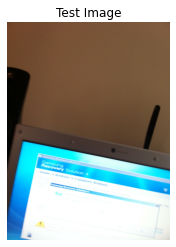

Question: Can anyone tell me what's actually on the screen of the laptop?
Actual Answer: unsuitable image
Predicted Answer: unanswerable


In [24]:
visualize_vqa_result(processor, model, val_df, index=31)